In [1]:
import pyspark
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local") \
    .config('spark.sql.autoBroadcastJoinThreshold', 0) \
    .config('spark.sql.adaptive.enabled', 'false') \
    .getOrCreate()

spark

In [2]:
# Imports
from pyspark.sql.functions import pandas_udf
from pyspark.sql.types import StringType, IntegerType, DoubleType
import pandas as pd

from pyspark.sql.window import Window
from pyspark.sql.functions import col, row_number

from pyspark.sql.column import Column
from pyspark.sql.column import _to_java_column
from pyspark.sql.column import _to_seq
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType
import timeit

In [3]:
videos = spark.read.option('header', 'true').option("inferSchema", "true").csv('../datasets/USvideos.csv')
# videos.show()

In [4]:
comments_schema = StructType([ \
    StructField("video_id", StringType(), True), \
    StructField("comment_text", StringType(), True), \
    StructField("likes", IntegerType(), True), \
    StructField("replies", IntegerType(), True)])
comments = spark.read.option('header', 'true').option("mode", "DROPMALFORMED").schema(comments_schema).csv('../datasets/UScomments.csv')
# comments.show()

In [5]:
category = (spark.read.option("multiline","true")
                .json("../datasets/US_category_id.json")
                .select(explode("items"))
                .select(col("col.id").alias("id"),col("col.snippet.title").alias("category"))
     )

In [6]:
# !pip install --no-cache-dir matplotlib
# !pip install --no-cache-dir seaborn

# Проверка распределения количества коментаникв у роликов

Text(0, 0.5, 'Count video')

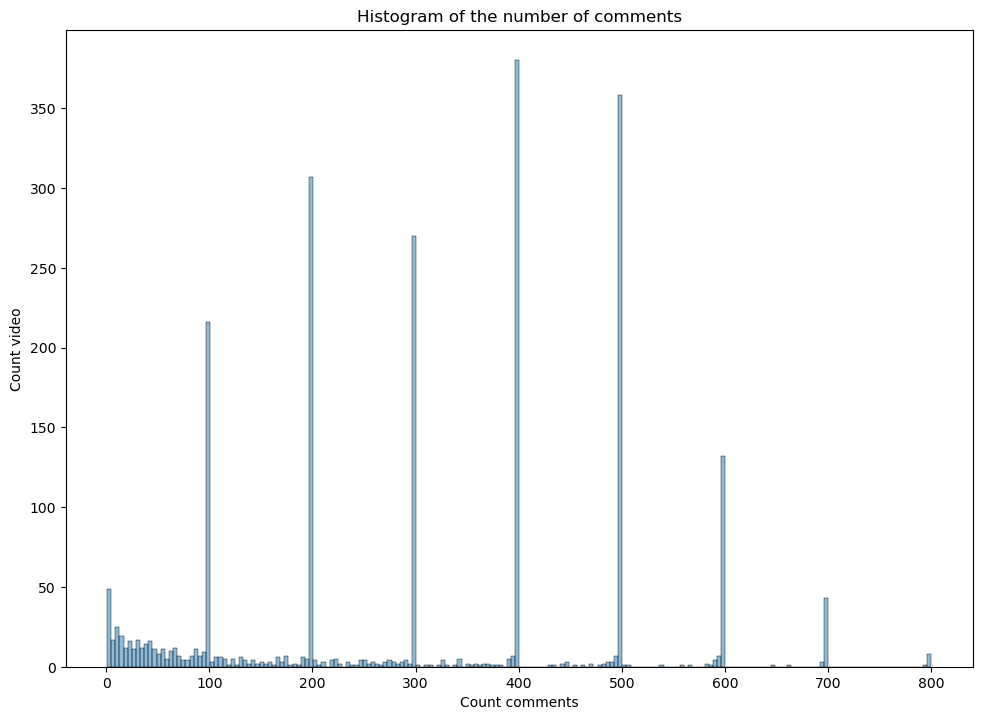

In [7]:
# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns

pandasDF = comments.groupby(col('video_id')).count().toPandas()

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

# seaborn histogram
sns.histplot(pandasDF["count"]
             , ax=ax
             , kde=False
             , bins=int(1000/5)
             , alpha = 0.5
             )

# Add labels
plt.title('Histogram of the number of comments')
plt.xlabel('Count comments')
plt.ylabel('Count video')

# Пункт 1

In [8]:
# Так как количество коментариев распределено неравномерно можно применить оптимизацию с добавлением соли

comments_salt = comments.withColumn('salt', (rand() * 3).cast('int'))

videos_salt = videos \
    .withColumn("salt", explode(array([lit(i) for i in [0, 1, 2]])))

scored_videos_bfr_agg = (videos_salt
                .join(comments_salt, ['video_id', 'salt'],"left")
                .select(
                       videos_salt['video_id']
                       , videos_salt['title']
                       , videos_salt['channel_title']
                       , videos_salt['category_id']
                       , videos_salt['tags']
                       , videos_salt['views']
                       , videos_salt['likes']
                       , videos_salt['dislikes']
                       , videos_salt['comment_total']
                       , videos_salt['thumbnail_link']
                       , to_date(concat(videos_salt['date'],lit(".2023")),"dd.MM.yyyy").alias("date")
                       , comments_salt['comment_text']
                       , comments_salt['likes'].alias("commnet_likes")
                       , comments_salt['replies'].alias("commnet_replies")
                )
                .drop('salt'))

In [9]:
comments_salt.show(2)

+-----------+--------------------+-----+-------+----+
|   video_id|        comment_text|likes|replies|salt|
+-----------+--------------------+-----+-------+----+
|XpVt6Z1Gjjo|Logan Paul it's y...|    4|      0|   0|
|XpVt6Z1Gjjo|I've been followi...|    3|      0|   2|
+-----------+--------------------+-----+-------+----+
only showing top 2 rows



In [10]:
@pandas_udf(DoubleType())
def calc_score(views: pd.Series, likes: pd.Series, dislikes: pd.Series, commnet_likes: pd.Series, commnet_replies: pd.Series) -> pd.Series:
    return (views + commnet_likes + commnet_replies) / dislikes * likes

# Using UDF with select()
# scored_videos.select(to_upper("views","likes","dislikes","commnet_likes","commnet_replies")).show()

# Using UDF with withColumn()
# scored_videos.withColumn("upper_col",to_upper("views","likes","dislikes","commnet_likes","commnet_replies")).show()

In [19]:
windowDate = Window.partitionBy("video_id").orderBy(col("date").desc())


scored_videos = (scored_videos_bfr_agg.groupBy("video_id"
                       , "title"
                       , "channel_title"
                       , "category_id"
                       , "tags"
                       , "views"
                       , "likes"
                       , "dislikes"
                       , "comment_total"
                       , "thumbnail_link"
                       , "date")
                       .agg(sum("commnet_likes").alias("sum_likes"),         
                            sum("commnet_replies").alias("sum_replies")
                           )
                       .withColumn("row",row_number().over(windowDate))
                       .filter(col("row") == 1)
                       .drop("row")
                       .withColumn("score" 
                                   , round(calc_score("views"
                                                , "likes"
                                                , "dislikes"
                                                , "sum_likes"
                                                , "sum_likes"
                                           ), 0).cast(IntegerType())
                       )
                       .drop("sum_likes")
                       .drop("sum_replies")
)

scored_videos.show(10)

+-----------+--------------------+----------------+-----------+--------------------+-------+------+--------+-------------+--------------------+----------+---------+
|   video_id|               title|   channel_title|category_id|                tags|  views| likes|dislikes|comment_total|      thumbnail_link|      date|    score|
+-----------+--------------------+----------------+-----------+--------------------+-------+------+--------+-------------+--------------------+----------+---------+
|4yCkkOvIkUI|EXCLUSIVE: Zonniq...|        YBF Chic|         24|              [none]|   5662|    33|      21|           13|https://i.ytimg.c...|2023-10-06|     9011|
|7TN09IP5JuI|Terry Crews Hallu...|  First We Feast|         26|First we feast|fw...|5066207|196868|    2083|        22920|https://i.ytimg.c...|2023-10-10|478822576|
|Bo-qp-Zu0OY|Meeting Talking D...|    TouringPlans|         19|talking mickey|ta...|  21654|   179|       1|           30|https://i.ytimg.c...|2023-09-30|  3901484|
|JkqTeQHFo

# Пункт 2

In [12]:
def get_median(df: pd.DataFrame) -> pd.DataFrame:
    return pd.DataFrame(df.groupby(["category"])["score"].median()).reset_index() 

In [13]:
# так как таблица category маленькая ее можно заброадкастить
bc_category = broadcast(category)

categories_score = (scored_videos 
    .join(bc_category, scored_videos['category_id'] == bc_category['id']) 
    .select(bc_category["category"],scored_videos["score"])
    .groupby("category").applyInPandas(get_median, "category string, score int")
)

categories_score.show(100)

# categories_score.show()

+--------------------+----------+
|            category|     score|
+--------------------+----------+
|               Shows|    113341|
|           Education|  14420106|
|              Gaming|   7802270|
|       Entertainment|  11426582|
|     Travel & Events|  12359104|
|Science & Technology|  11559558|
|              Sports|   3406357|
|       Howto & Style|  13730344|
|Nonprofits & Acti...|1074189006|
|    Film & Animation|  13132268|
|      People & Blogs|  10955716|
|     News & Politics|    926484|
|      Pets & Animals|  15239595|
|    Autos & Vehicles|   5718967|
|               Music|  16500100|
|              Comedy|  23844659|
+--------------------+----------+



# Пункт 3

In [14]:
sc = spark.sparkContext

def udfSplitTagsUDFScalaWrapper(ipString):
    _splitTagsUDF = sc._jvm.CustomUDFs.splitTagsUDF()
    return Column(_splitTagsUDF.apply(_to_seq(sc, [ipString], _to_java_column)))

split_tags = videos.select("tags",udfSplitTagsUDFScalaWrapper(col("tags")).alias("split_tags_scala"))

timeit.timeit('split_tags.count()', number=1, globals=globals())

0.2454037030111067

In [15]:
@pandas_udf(ArrayType(StringType()))
def split_string(column: pd.Series) -> pd.Series:
    return column.str.split("|")


split_tags = videos.select(split_string("tags").alias("tags"))

timeit.timeit('split_tags.count()', number=1, globals=globals())

0.17867142500472255

In [16]:
popular_tags = (split_tags
 .select(explode("tags").alias("tag"))
 .where("tag != '[none]'")
 .groupBy("tag").count()
 .sort(col("count").desc())
 )

popular_tags.show(10)


+--------+-----+
|     tag|count|
+--------+-----+
|   funny|  722|
|  comedy|  572|
|    2017|  309|
|  how to|  284|
|    vlog|  273|
|   humor|  258|
|  makeup|  254|
|   music|  250|
|tutorial|  235|
|    food|  224|
+--------+-----+
only showing top 10 rows



# Пункт 4

In [18]:
top_cat_comments = (scored_videos_bfr_agg
 .select("comment_text","commnet_likes",split_string("tags").alias("tags"))
 .select("comment_text","commnet_likes",explode("tags").alias("tag"))
 .where("tag = 'cat'")
 .groupBy("comment_text").count()
 .sort(col("count").desc())
)

top_cat_comments.show(5,False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|comment_text                                                                                                                                                                                                                                                                                                                                                                                           |count|
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------